## Support Vector Machines




In [33]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "sk2torch"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass


# here we create and (potentially train a model)

# make sure you have the dependencies required here already installed
import json
import numpy as np
from sklearn.svm import SVC
import sk2torch
import torch
import ezkl
import os


# Create a dataset of two Gaussians. There will be some overlap
# between the two classes, which adds some uncertainty to the model.
xs = np.concatenate(
    [
        np.random.random(size=(256, 2)) + [1, 0],
        np.random.random(size=(256, 2)) + [-1, 0],
    ],
    axis=0,
)
ys = np.array([False] * 256 + [True] * 256)

# Train an SVM on the data and wrap it in PyTorch.
sk_model = SVC(probability=True)
sk_model.fit(xs, ys)
model = sk2torch.wrap(sk_model)







In [34]:
model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

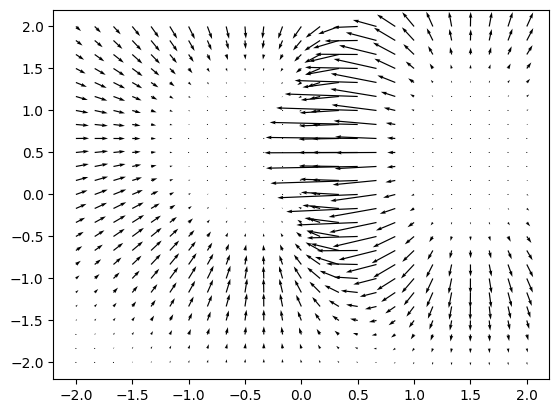

In [38]:
import matplotlib.pyplot as plt
# Create a coordinate grid to compute a vector field on.
spaced = np.linspace(-2, 2, num=25)
grid_xs = torch.tensor([[x, y] for x in spaced for y in spaced], requires_grad=True)


# Compute the gradients of the SVM output.
outputs = model.predict_proba(grid_xs)[:, 1]
(input_grads,) = torch.autograd.grad(outputs.sum(), (grid_xs,))


# Create a quiver plot of the vector field.
plt.quiver(
    grid_xs[:, 0].detach().numpy(),
    grid_xs[:, 1].detach().numpy(),
    input_grads[:, 0].detach().numpy(),
    input_grads[:, 1].detach().numpy(),
)
plt.savefig("svm_vector_field.png")

In [40]:


# export to onnx format
# !!!!!!!!!!!!!!!!! This will flash a warning but it is fine !!!!!!!!!!!!!!!!!!!!!

# Input to the model
shape = xs.shape[1:]
x = grid_xs[0:1]
torch_out = model.predict(x)
# Export the model
torch.onnx.export(model,               # model being run
                  # model input (or a tuple for multiple inputs)
                  x,
                  # where to save the model (can be a file or file-like object)
                  "network.onnx",
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names=['input'],   # the model's input names
                  output_names=['output'],  # the model's output names
                  dynamic_axes={'input': {0: 'batch_size'},    # variable length axes
                                'output': {0: 'batch_size'}})

d = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_shapes=[shape],
            input_data=[d],
            output_data=[o.reshape([-1]).tolist() for o in torch_out])

# Serialize data into file:
json.dump(data, open("input.json", 'w'))


================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



/Users/alexandercamuto/Documents/GitHub/ezkl/.env/lib/python3.9/site-packages/sk2torch/svc.py:193: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  votes = torch.zeros((len(x), self.n_classes)).to(kernel_out)
/Users/alexandercamuto/Documents/GitHub/ezkl/.env/lib/python3.9/site-packages/sk2torch/svc.py:195: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  torch.zeros(len(x)).to(kernel_out) for i in range(self.n_classes)


AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [15]:
!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path)
assert res == True

res = await ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")
assert res == True

thread '<unnamed>' panicked at 'not yet implemented', src/graph/utilities.rs:145:14


PanicException: not yet implemented

In [ ]:
res = ezkl.compile_model(model_path, compiled_model_path, settings_path)
assert res == True

In [ ]:
# srs path
res = ezkl.get_srs(srs_path, settings_path)

In [ ]:
# now generate the witness file 

res = ezkl.gen_witness(data_path, compiled_model_path, witness_path, settings_path = settings_path)
assert os.path.isfile(witness_path)

In [ ]:

# HERE WE SETUP THE CIRCUIT PARAMS
# WE GOT KEYS
# WE GOT CIRCUIT PARAMETERS
# EVERYTHING ANYONE HAS EVER NEEDED FOR ZK



res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
        settings_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [ ]:
# GENERATE A PROOF


proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "evm",
        "single",
        settings_path,
    )

print(res)
assert os.path.isfile(proof_path)

In [ ]:
# VERIFY IT

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")